In [1]:
!nvidia-smi

Fri Sep 17 17:44:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
 !mkdir -p ~/.kaggle
 !mv kaggle.json ~/.kaggle/
 !ls ~/.kaggle
 !chmod 600 /root/.kaggle/kaggle.json
 !kaggle datasets download -d sixhky/open-images-bus-trucks/
 !unzip -qq open-images-bus-trucks.zip
 !rm open-images-bus-trucks.zip

kaggle.json
 97% 357M/367M [00:04<00:00, 156MB/s]
100% 367M/367M [00:04<00:00, 88.2MB/s]


In [3]:
!pip install torch-snippets

     |████████████████████████████████| 42 kB 686 kB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 10.1 MB 32.6 MB/s 
     |████████████████████████████████| 211 kB 45.6 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 


In [4]:
from PIL import Image
from torch_snippets import *
import numpy as np
import pandas as pd
import cv2
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy import moveaxis
from numpy import asarray
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

2021-09-17 17:45:05.010 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [5]:
DF_RAW=pd.read_csv('/content/df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
img_folder='/content/images/images/'

In [8]:
class OpenDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df=df
  def __len__(self):
    return len(self.df)
  def __getitem__(self, ix):
    img_id=self.df.iloc[ix, 0]
    img_id=img_id+'.jpg'
    img_path=os.path.join(img_folder, img_id)
    img=(cv2.imread(img_path)[:,:,::-1])
    img=cv2.resize(img, (224, 224))/255
    box_pts=self.df.iloc[ix, 4:8].values
    temp=box_pts[2]
    box_pts[2]=box_pts[1]
    box_pts[1]=temp
    img_class=self.df.iloc[ix, 2]
    if (img_class=='Bus'):
      img_class=[1]
    elif (img_class=='Truck'):
      img_class=[2]
    box_pts=[(box_pts* np.array([224,224,224,224])).astype(np.uint16).tolist()]
    target={}
    target["boxes"]=torch.tensor(box_pts).float().to(device)
    target["labels"]=torch.tensor(img_class).long().to(device)
    img=asarray(img)
    img=moveaxis(img, 2, 0)
    img = torch.tensor(img)      
    return img.to(device).float(), target
  def collate_fn(self, batch):
    return tuple(zip(*batch))

In [9]:
od=OpenDataset(DF_RAW)
img, target=od[0]
print(target)

{'boxes': tensor([[ 77.,  34., 203., 145.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}


In [10]:
from torch.utils.data import DataLoader

In [11]:
train_ds=OpenDataset(DF_RAW[:1000])
train_loader=DataLoader(train_ds, batch_size=8, collate_fn=train_ds.collate_fn ,drop_last=True)

In [12]:
def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
  return model.to(device)

In [13]:
def train_batch(images, targets, model, optimizer):
 model.train()
 input = list(image for image in images)
 targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
 optimizer.zero_grad()
 losses = model(input, targets)
 loss = sum(loss for loss in losses.values())
 loss.backward()
 optimizer.step()
 return loss, losses

In [14]:
model=get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9,weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [15]:
Loss=[]
for epoch in range(0, 10):
  print(epoch)
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    img, target = inputs
    loss, losses = train_batch(img, target, model, optimizer)
    batch_loss.append(loss.item())
  Loss.append(np.mean(batch_loss))

0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1
2
3
4
5
6
7
8
9


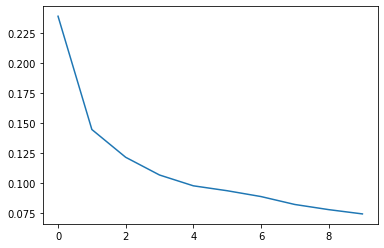

In [16]:
plt.plot(Loss)

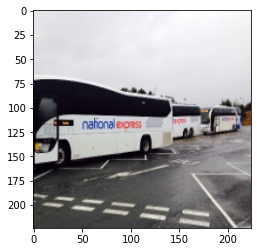

In [17]:
img_path='/content/images/images/00751332f75e12d2.jpg'
img=(cv2.imread(img_path)[:,:,::-1])
img=cv2.resize(img, (224, 224))/255
img1=img
plt.imshow(img)

In [18]:
model.eval()
img=asarray(img)
img=moveaxis(img, 2, 0)
img = torch.tensor(img).float().view(-1, 3, 224, 224).to(device)
target_final=model(img)
print(target_final)

[{'boxes': tensor([[  7.4044,  65.1532, 141.4270, 160.3070],
        [142.5367,  95.7822, 171.0694, 132.3210],
        [172.1178,  96.1946, 211.1422, 127.6178]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9385, 0.8182, 0.7696], device='cuda:0', grad_fn=<IndexBackward>)}]


In [19]:
result=target_final[0]['boxes'].cpu().detach().numpy()
print(result)
label=target_final[0]['labels'].cpu().detach().numpy()
print(label)
labels=['Bus', 'Bus', 'Bus']

[[  7.404384  65.1532   141.427    160.30699 ]
 [142.53668   95.78223  171.06937  132.32101 ]
 [172.1178    96.19459  211.14215  127.61777 ]]
[1 1 1]


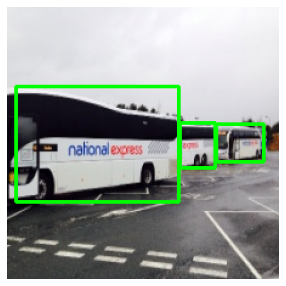

In [20]:
img10=read('/content/images/images/00751332f75e12d2.jpg', 1)
img10=cv2.resize(img10, (224, 224))
show(img10, bbs=result, label=labels, sz=5)

In [21]:
torch.save(model.to('cpu').state_dict(), 'Faster_RCNN.pth')